# Network Analysis


In [20]:
import numpy as np
import pandas as pd


One data type we have not looked at in much detail is the network. Social
networking is one of the largest drivers of internet use at present, and
analysis of cliques, influencers, (fake) news spread and bots is now a serious
topic.


## Business Applications

Network analysis is used in many domains, but some notable examples are:

- [Food Discovery with Uber Eats (Recommendation Systems)](https://eng.uber.com/uber-eats-graph-learning/)
- [Google's Webpage Ranking Through the PageRank Algorithm](https://en.wikipedia.org/wiki/PageRank)
- [Social Network Analysis](https://arxiv.org/abs/2107.05731)

The idea behind network analysis is to model a problem a collection of
relationships between entities. Some problems are easier to model as such (e.g.
social networks, page links, transactions from buyer to seller).


## Network Basics

Network are often called **Graphs**, and much of the vocabulary used in network
analysis refers to graphs.

We can think of a network as consisting of two major items:

**Nodes**: A node is a unit in the network - A user, item, location or website.

**Edges**: An edge is a connection between nodes. A Facebook friendship, a link
between sites, a purchase of an item, or connecting flight between cities.

Based on the way these entities are chosen, we can have several types of
networks:

- Undirected - Any edge between nodes is symmetrical (Such as a Facebook
  friendship).
- Directed - Any edge is non-symmetrical (Such as following someone on twitter).
- Weighted - Any edge carries with it some weight - such as as proportion.
- Unweighted - Each edge is treated identically.

We can also have networks that allow multiple connections between the same nodes
(multi-graphs), but we will not cover these today.


Let's plot a few out to show some examples. The `networkx` Python package
(Documentation [here](https://networkx.org/documentation/stable/tutorial.html))
provides us with many analysis tools for working with network data. It can also
perform basic visualization , but for network visualizations we will use `pyvis`
(Documentation [here](https://pyvis.readthedocs.io/en/latest/tutorial.html))


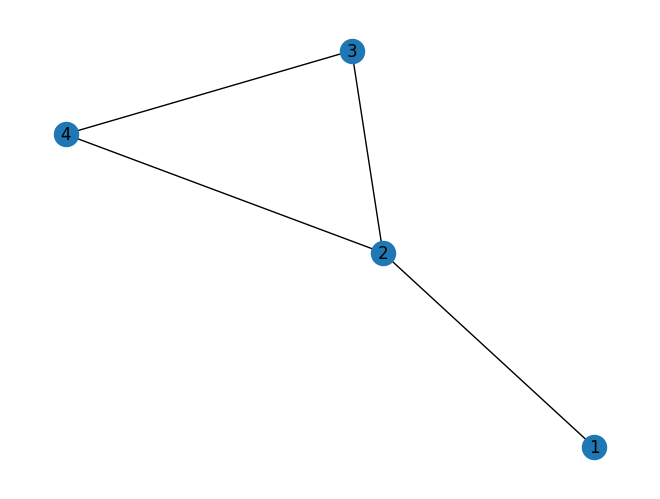

In [2]:
import networkx as nx

# Graph is an undirected network
network = nx.Graph()

# Adding edges one at a time
network.add_edge(1, 2)
network.add_edge(2, 3)

# Adding edges from a list of tuples
network.add_edges_from([(4, 2), (4, 3)])

nx.draw(network, with_labels=True)


In [3]:
from pyvis.network import Network

pyvis_network = Network("300px", "300px", notebook=True)
pyvis_network.from_nx(network)

# The network is interactive
pyvis_network.show("sample_network.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


When visualizing with `pyvis`, the default visualization is dynamic and responds
to user interaction through a physics simulation, but we can turn that off for
easier manipulation of the network.


In [4]:
pyvis_network = Network("300px", "300px", notebook=True)
pyvis_network.from_nx(network)

# You can turn off physics simulations to make sure nodes stay
# where you drag them
pyvis_network.toggle_physics(False)

pyvis_network.show("sample_network_no_physics.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


A network can have **undirected** edges (e.g. if I am friends with someone on
Facebook, they are friends with me, so the relationship is always symmetric), or
it can have **directed** edges (e.g. If I am flying from New York to Tokyo, I am
not simultaneously flying from Tokyo to New York, the relationship is not
symmetric).


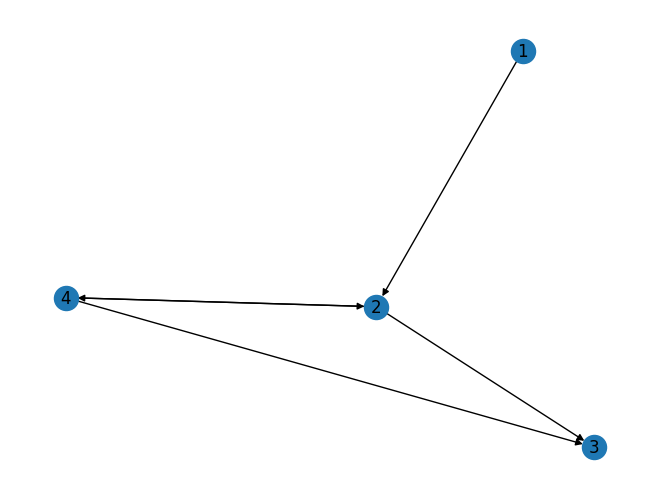

In [5]:
# Directed
directed_network = nx.DiGraph()
directed_network.add_edges_from([(1, 2), (2, 3), (2, 4)])
directed_network.add_edges_from([(4, 2), (4, 3)])

nx.draw(directed_network, with_labels=True)


In [6]:
directed_pyvis_network = Network(
    "300px", "300px", notebook=True, directed=True
)  # We have to explicitly describe the network as directed
directed_pyvis_network.from_nx(directed_network)
directed_pyvis_network.show("sample_directed_network.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


For the purposes of this notebook, we will explore the more common
**undirected** network


### Network Connectivity Basics

Let's take a step back and walk through a small social network example. We will
import a `.gml` file, a common file type for storing network data.

This file captures the social relationships across a group of 62 bottlenose
dolphins living off the coast of New Zealand. Each node is a dolphin and each
edge represents a frequent association between 2 dolphins:


In [21]:
dolphin_network = nx.read_gml("../_data/dolphins.gml")

dolphin_pyvis_network = Network("500px", "100%", notebook=True)
dolphin_pyvis_network.from_nx(dolphin_network)

# dolphin_pyvis_network.toggle_physics(False)
dolphin_pyvis_network.show("dolphin_network.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


We can immediately see that there appear to be 2 main clusters, and that some
dolphins are more socially central while others are on the periphery.

Let's walk through a few basic functions from the `networkx` API:


In [22]:
# Number of nodes
print(f"number of nodes {len(dolphin_network)}")

# Number of edges:
print(f"total edges: {len(dolphin_network.edges())}")

# View first 5 edges:
print(f"first few edges: {list(dolphin_network.edges())[:5]}")


number of nodes 62
total edges: 159
first few edges: [('Beak', 'Fish'), ('Beak', 'Grin'), ('Beak', 'Haecksel'), ('Beak', 'SN9'), ('Beak', 'SN96')]


In [23]:
# List the connections (i.e. neighbors) of the dolphin named 'Beak'
list(dolphin_network.neighbors("Beak"))


['Fish', 'Grin', 'Haecksel', 'SN9', 'SN96', 'TR77']

In [24]:
# Let's showcase this in our network
dolphin_pyvis_network.get_node("Beak")["color"] = {
    "background": "rgba(255,255,0,255)",
    "highlight": {"background": "rgba(255,234,30,1)"},
}

for neighbor in list(dolphin_pyvis_network.neighbors("Beak")):
    dolphin_pyvis_network.get_node(neighbor)["color"] = {"background": "rgba(255,125,125,255)"}

dolphin_pyvis_network.toggle_physics(False)
dolphin_pyvis_network.show("dolphin_network_beak.html")


## Measures of Centrality

We can now see which individuals have the most connections. Social network
analysis will often try to find the most "connected" individuals. If we know
someone has a large number of connections, we can pay them to promote our
product, designate them as a leader, or remove them, depending on our exact
goals.

However, the nodes with the most connections might not be the ones who are most
important! There are many ways to measure the "connectedness" of a node. These
measures are called **_centrality_** metrics.


### Degree

We've already seen the most basic measure of centrality: which node has the most
neighbors. This is called the **_degree_** of a node. There's a quick `networkx`
function to calculate this across the entire network:


In [25]:
degree_df = pd.DataFrame.from_dict(dict(nx.degree(dolphin_network)), orient="index")
degree_df = degree_df.reset_index()
degree_df.columns = ["Dolphin", "Degree"]

degree_df.sort_values(by="Degree", ascending=False).head()


,Dolphin,Degree
14,Grin,12
37,SN4,11
45,Topless,11
33,Scabs,10
51,Trigger,10


We can see here that the dolphin named 'Grin' has the most friends.


In [12]:
dolphin_pyvis_network = Network("500px", "100%", notebook=True)
dolphin_pyvis_network.from_nx(dolphin_network)

dolphin_pyvis_network.get_node("Grin")["color"] = {
    "background": "rgba(255,255,0,1)",
    "highlight": {"background": "rgba(255,234,30,1)"},
}

for neighbor in list(dolphin_pyvis_network.neighbors("Grin")):
    dolphin_pyvis_network.get_node(neighbor)["color"] = {"background": "rgba(255,125,125,1)"}

# dolphin_pyvis_network.toggle_physics(False)
dolphin_pyvis_network.show("dolphin_network_grin.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Degree centrality doesn't tell the whole story though. Imagine we have a network
with a small & densely connected portion in one section, but a vast number of
lightly connected nodes that extend outward for miles. These densely connected
nodes might have the highest degree, but they're quite isolated from the rest of
the network — not very central at all.


### Closeness

Another important concept when assessing the centrality of a node is its
shortest path to other nodes in the network:


In [26]:
# Beak & Grin are directly connected
print(nx.shortest_path(dolphin_network, "Beak", "Grin"))

# Beak & Thumper are 3 steps away from one another
print(nx.shortest_path(dolphin_network, "Beak", "Thumper"))


['Beak', 'Grin']
['Beak', 'Fish', 'Bumper', 'Thumper']


**_Closeness_** centrality measures a node's average shortest path length to
each of the other nodes. A node with a high closeness score will be able to
share information with each of the other nodes quickest on average.


In [27]:
# The closeness is normalized by the number of nodes, and is returned as a dictionary
closeness_df = pd.DataFrame.from_dict(nx.closeness_centrality(dolphin_network), orient="index")
closeness_df = closeness_df.reset_index()
closeness_df.columns = ["Dolphin", "Closeness"]

closeness_df.sort_values(by="Closeness", ascending=False).head()


,Dolphin,Closeness
36,SN100,0.417808
40,SN9,0.403974
37,SN4,0.398693
20,Kringel,0.391026
14,Grin,0.376543


In [28]:
# Drawing our network with some extra settings defined for readability
centralities = nx.closeness_centrality(dolphin_network)

dolphin_pyvis_network = Network("500px", "100%", notebook=True)
dolphin_pyvis_network.from_nx(dolphin_network)

for node in dolphin_pyvis_network.nodes:
    dolphin_pyvis_network.get_node(node["id"])["size"] = np.exp(centralities[node["id"]] * 7.5)

dolphin_pyvis_network.get_node("SN100")["color"] = {"background": "rgba(255,0,0,255)"}
dolphin_pyvis_network.get_node("SN9")["color"] = {"background": "rgba(255,0,0,255)"}
dolphin_pyvis_network.get_node("SN4")["color"] = {"background": "rgba(255,0,0,255)"}
dolphin_pyvis_network.get_node("Grin")["color"] = {"background": "rgba(255,255,0,1)"}

# dolphin_pyvis_network.toggle_physics(False)
dolphin_pyvis_network.show("dolphin_network_closeness.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Notice that the dolphins with the highest closeness centrality (SN100, SN9, SN4)
are closer to the middle of the network rather than being at the hub of a
particular cluster like Grin.


### Betweenness

**_Betweenness_** centrality takes this idea a step further. It asks, how many
of the network's shortest paths does a node lie on? Nodes with high betweenness
centrality are key to controlling the flow of information and maintaining the
network's overall connectivity.


In [14]:
betweenness_df = pd.DataFrame.from_dict(nx.betweenness_centrality(dolphin_network), orient="index")
betweenness_df = betweenness_df.reset_index()
betweenness_df.columns = ["Dolphin", "Betweenness"]

betweenness_df.sort_values(by="Betweenness", ascending=False).head(10)


,Dolphin,Betweenness
36,SN100,0.248237
1,Beescratch,0.213324
40,SN9,0.143150
37,SN4,0.138570
7,DN63,0.118239
17,Jet,0.114300
20,Kringel,0.102646
54,Upbang,0.099122
51,Trigger,0.084677
57,Web,0.084205


In [29]:
betweenness_centralities = nx.betweenness_centrality(dolphin_network)

dolphin_pyvis_network = Network("500px", "100%", notebook=True)
dolphin_pyvis_network.from_nx(dolphin_network)

for i, node in enumerate(dolphin_pyvis_network.nodes):
    dolphin_pyvis_network.get_node(node["id"])["size"] = np.power(
        (betweenness_centralities[node["id"]] + 0.1) * 30, 1.5
    )

dolphin_pyvis_network.get_node("SN100")["color"] = {"background": "rgba(255,0,0,255)"}
dolphin_pyvis_network.get_node("SN9")["color"] = {"background": "rgba(255,0,0,255)"}
dolphin_pyvis_network.get_node("Beescratch")["color"] = {"background": "rgba(255,0,0,255)"}

# dolphin_pyvis_network.toggle_physics(False)
dolphin_pyvis_network.show("dolphin_network_betweeness.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Notice that the dolphins with high betweenness centrality (SN100, Beescratch,
SN9) are located at the chokepoints in the network. Were they to be removed, the
two clusters would risk losing their connectivity. And our friend Grin, who had
the most neighbors overall, isn't even in the top 10 most central nodes by this
measure.


In [30]:
reduced_dolphin_network = dolphin_network.copy()

# Remove our chokepoint dolphins
reduced_dolphin_network.remove_node("SN100")
reduced_dolphin_network.remove_node("Beescratch")
reduced_dolphin_network.remove_node("SN9")

# There's one more dolphin holding the group together after
# the previous 3 are removed
reduced_dolphin_network.remove_node("PL")

betweenness_centralities = nx.betweenness_centrality(reduced_dolphin_network)

dolphin_pyvis_network = Network("500px", "100%", notebook=True)
dolphin_pyvis_network.from_nx(reduced_dolphin_network)

for i, node in enumerate(dolphin_pyvis_network.nodes):
    dolphin_pyvis_network.get_node(node["id"])["size"] = np.power(
        (betweenness_centralities[node["id"]] + 0.1) * 30, 1.5
    )

# The networks are still drawn to each other
# due to the physics simulation of pyvis

# dolphin_pyvis_network.toggle_physics(False)
dolphin_pyvis_network.show("dolphin_network_reduced.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Betweenness is a key metric of a number of network models. For example, a power
distribution network might seek to limit the overall betweenness centrality of
its network to reduce the impact of outages.


## Facebook Data

Let's explorer a larger, more intuitive network. The following code loads a
network of anonymized Facebook profiles taken from
[here](https://snap.stanford.edu/data/ego-Facebook.html). For ease of
computation we've reduced the network, and assigned each anonymized node with a
random name.


In [31]:
facebook_network = nx.read_gml("../_data/facebook_reduced.gml")

facebook_pyvis_network = Network("700px", "100%", notebook=True)

# These settings make sure the
# network doesn't take long to stabilize from the
# physics simulation
facebook_pyvis_network.barnes_hut(spring_strength=0.004, damping=0.18, gravity=-800, spring_length=50)
facebook_pyvis_network.from_nx(facebook_network)

# facebook_pyvis_network.toggle_physics(False)
facebook_pyvis_network.show("facebook_network_ex1.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


---

#### Exercise 1

1. Find the degree of each user in the dataset. Which are the ten most popular
   users by this measure? Check the top 10 users by closeness, and betweenness
   as well

2. Is our network completely connected? How many fully connected components are
   present? (Hint: `networkx` has some built-in functions to help with these.)


In [32]:
# 1. Find the degree of each user in the dataset. Which are the ten most popular users by this measure?
#    Check the top 10 users by closeness, and betweenness as well

degree_df = pd.DataFrame.from_dict(dict(nx.degree(facebook_network)), orient="index")
degree_df = degree_df.reset_index()
degree_df.columns = ["user", "degree"]

closeness_df = pd.DataFrame.from_dict(dict(nx.closeness_centrality(facebook_network)), orient="index")
closeness_df = closeness_df.reset_index()
closeness_df.columns = ["user", "closeness_centrality"]

betweenness_df = pd.DataFrame.from_dict(dict(nx.betweenness_centrality(facebook_network)), orient="index")
betweenness_df = betweenness_df.reset_index()
betweenness_df.columns = ["user", "betweenness_centrality"]

degree_closeneess_df = pd.merge(degree_df, closeness_df, on="user", how="inner")
combined_df = pd.merge(degree_closeneess_df, betweenness_df, on="user", how="inner")

display(combined_df.sort_values(by="degree", ascending=False).head(10))


,user,degree,closeness_centrality,betweenness_centrality
0,Dorothy Robinson,13,0.222401,0.168090
133,Nicole Drayton,12,0.221134,0.062681
87,Kristine Jaynes,12,0.219260,0.048995
20,Fannie Krueger,11,0.218028,0.033725
101,Paul Hutching,11,0.227619,0.049400
141,Nina Wang,10,0.209778,0.027537
32,Janis Reynolds,10,0.190474,0.030044
71,Wendy Dobies,10,0.228962,0.051034
51,Ted Robinson,9,0.207258,0.034562
127,Kevin Roman,9,0.217722,0.063128


In [33]:
# 2. Is our network completely connected? How many fully connected components are present?
#    (Hint: `networkx` has some built-in functions to help with these.)

number_of_components = len(list(nx.connected_components(facebook_network)))
number_of_components


14

---


### Community Detection

Aside from assessing centrality within a network, which focuses on individual
nodes, another major area of network analysis is community detection, which
focuses on groups of nodes.

_**Cliques**_ are groups of nodes in which each individual node is connected to
every other node. It maps nicely to our idea of social cliques: a group of
friends that are all friends with each other. For each node, there is (at least)
one maximally sized clique that it is a member of.


In [41]:
for i, clique in enumerate(nx.find_cliques(dolphin_network)):  # this is a generator
    if i < 5:
        print(clique)


['Topless', 'Zap', 'Double']
['Topless', 'Zap', 'Haecksel']
['Topless', 'Double', 'SN4']
['Topless', 'Trigger', 'MN60']
['Topless', 'Trigger', 'TR99']


We can use cliques to understand sub-groupings of our graphs, and for further
analysis.


### Clustering Within a Network

_**Clusters**_ are groups of nodes that are more densely connected with each
other than they are with the rest of the network. Nodes in clusters (likely)
aren't connected to every single other node in the cluster, but we see denser
connections among nodes within clusters.

We see 2 obvious clusters in our dolphin social network:


In [35]:
dolphin_pyvis_network = Network("500px", "100%", notebook=True)
dolphin_pyvis_network.from_nx(dolphin_network)

# dolphin_pyvis_network.toggle_physics(False)
dolphin_pyvis_network.show("dolphin_network.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


How can we quantitatively assess how "clustered" a network is?

We can use a metric called the _clustering coefficient_. The **local**
clustering coefficient describes, for each node, what proportion of its
connections are connected to one another.


In [36]:
clustering_df = pd.DataFrame.from_dict(nx.clustering(dolphin_network), orient="index")
clustering_df = clustering_df.reset_index()
clustering_df.columns = ["Dolphin", "Clustering Coefficient"]

clustering_df.sort_values(by="Clustering Coefficient", ascending=False).head()


,Dolphin,Clustering Coefficient
25,Mus,0.666667
26,Notch,0.666667
16,Hook,0.600000
41,SN90,0.600000
6,DN21,0.533333


In [37]:
clustering_coefs = nx.clustering(dolphin_network)

dolphin_pyvis_network = Network("500px", "100%", notebook=True)
dolphin_pyvis_network.from_nx(dolphin_network)

for i, node in enumerate(dolphin_pyvis_network.nodes):
    dolphin_pyvis_network.get_node(node["id"])["size"] = np.exp(clustering_coefs[node["id"]] * 5)

# dolphin_pyvis_network.toggle_physics(False)
dolphin_pyvis_network.show("dolphin_network_cluster.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Basically, if a node has a high clustering coefficient, its neighbors are also
neighbors with each other. For example, in our dolphins network, nodes that have
a high clustering coefficient are dolphins whose friends are also friends with
each other.


To describe the network's overall tendency towards being clustered, we can take
the average of the local clustering coefficient across every node in the
network. This metric is called the **global** clustering coefficient.


In [38]:
nx.average_clustering(dolphin_network)


0.2589582460550202

How can we quantitatively identify these clusters?

There are a number of algorithms that iterate through the graph to assess
connection density and assign nodes to different clusters.


In [39]:
from networkx.algorithms.community import greedy_modularity_communities

clusters = greedy_modularity_communities(dolphin_network)

print(f"The dolphin social network has {len(clusters)} clusters.")


The dolphin social network has 4 clusters.


Often when visualizing a network, we'll want to colour the nodes by their
cluster membership. This takes a bit of effort, but we can get it done.

First we need to add an attribute to each node containing its cluster number.
Then we define the node's colour by this attribute upon visualization.


In [40]:
# returns a list of sets
clusters = greedy_modularity_communities(dolphin_network)
colors = ["red", "purple", "blue", "yellow"]

dolphin_pyvis_network = Network("700px", "100%", notebook=True)
dolphin_pyvis_network.from_nx(dolphin_network)

# We can also provide a few additional properties to each node
# for a full list of properties (documented in JavaScript)
# https://visjs.github.io/vis-network/docs/network/nodes.html

for i, cluster in enumerate(clusters):
    for dolphin_name in cluster:
        dolphin_pyvis_network.get_node(dolphin_name)["color"] = {"background": colors[i]}

# dolphin_pyvis_network.toggle_physics(False)
dolphin_pyvis_network.show("dolphin_network_cluster2.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


---

#### Exercise 2

Consider our Facebook data again.

1. How many clusters do you expect this network to have? How many clusters does
   this dataset have?

2. Can you identify individuals which have a high degree of connections but low
   closeness centrality? Why do you think that is?


In [42]:
facebook_network = nx.read_gml("../_data/facebook_reduced.gml")

facebook_pyvis_network = Network("700px", "100%", notebook=True)

# These settings make sure the
# network doesn't take long to stabilize from the
# physics simulation
facebook_pyvis_network.barnes_hut(spring_strength=0.004, damping=0.18, gravity=-800, spring_length=50)
facebook_pyvis_network.from_nx(facebook_network)

# facebook_pyvis_network.toggle_physics(False)
facebook_pyvis_network.show("facebook_network.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [43]:
# 1. How many clusters does this dataset have?
clusters = greedy_modularity_communities(
    facebook_network,
)  # returns a list of sets

print(len(clusters))


23


In [44]:
# 2. Can you identify individuals which have a high degree of connections but low closeness centrality?
#    Why do you think that is?

# Create a dataframe of the node degrees
degree_df = pd.DataFrame.from_dict(dict(nx.degree(facebook_network)), orient="index")
degree_df = degree_df.reset_index()
degree_df.columns = ["user", "degree"]

# Create a dataframe of the node closeness centralities
closeness_df = pd.DataFrame.from_dict(dict(nx.closeness_centrality(facebook_network)), orient="index")
closeness_df = closeness_df.reset_index()
closeness_df.columns = ["user", "closeness_centrality"]

# Merge the two on the user
combined_df = pd.merge(degree_df, closeness_df, on="user", how="inner")

# Sort and show
combined_df.sort_values(by="degree", ascending=False).head(10)


,user,degree,closeness_centrality
0,Dorothy Robinson,13,0.222401
133,Nicole Drayton,12,0.221134
87,Kristine Jaynes,12,0.219260
20,Fannie Krueger,11,0.218028
101,Paul Hutching,11,0.227619
141,Nina Wang,10,0.209778
32,Janis Reynolds,10,0.190474
71,Wendy Dobies,10,0.228962
51,Ted Robinson,9,0.207258
127,Kevin Roman,9,0.217722


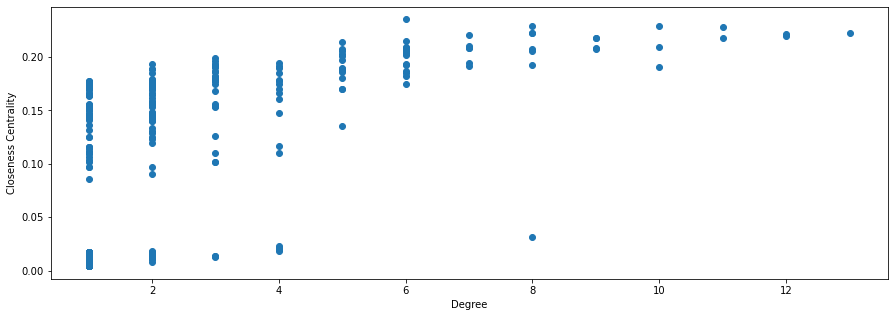

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.scatter(combined_df["degree"], combined_df["closeness_centrality"])
plt.xlabel("Degree")
plt.ylabel("Closeness Centrality")
plt.show()


In [35]:
combined_df[combined_df["degree"] == 8]


,user,degree,closeness_centrality
5,Allan Elkins,8,0.229300
26,Karl Newell,8,0.192600
59,Sharon Muncy,8,0.222720
70,Jack Wing,8,0.207258
78,Jo Cantave,8,0.222083
96,Charles Patterson,8,0.032000
149,Christopher Olofson,8,0.205339


Our node of interest seems to be Charles Patterson


In [45]:
facebook_network = nx.read_gml("../_data/facebook_reduced.gml")

facebook_pyvis_network = Network("700px", "100%", notebook=True)

# These settings make sure the
# network doesn't take long to stabilize from the
# physics simulation
facebook_pyvis_network.barnes_hut(spring_strength=0.004, damping=0.18, gravity=-800, spring_length=50)
facebook_pyvis_network.from_nx(facebook_network)

facebook_pyvis_network.get_node("Charles Patterson")["color"] = {"background": "yellow"}

# facebook_pyvis_network.toggle_physics(False)
facebook_pyvis_network.show("facebook_network_ex2.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


**Charles Patterson** has a high degree but low closeness since he is at the
center of a relatively small cluster outside the main network. Any node that is
added there, but is only connected to Charles will increase his degree but not
so much his centrality. This seems to be an isolated subgroup of users that are
centered around Charles. Perhaps a new group of users all recommended by a
single person who is also new and found Facebook very addicting.


### Conclusion


We've seen how the application of network analysis can uncover interesting
patterns in a connected set of entities in a toy dataset and an example from
social network analysis (SNA). Visualization is fundamental, and metrics such as
measures of centrality and the clustering coefficient also allow us to quantify
the properties of individual nodes, as well as a network overall.

Here we've only scratched the surface of how network analysis techniques can be
applied; as noted in the introduction, there are many more applications across
multiple subject matter domains. Network analysis techniques can also be
combined with supervised or unsupervised learning by treating it as a form of
feature engineering: if each row in the data model is a node in the network,
degree or other measures can be calculated as new features. These could be
important if the topology of a network is a highly predictive factor in a given
machine learning task.

Network analysis is often viewed as a specialized niche topic under the umbrella
of data science. However, if framed correctly, many problems across various
domains can benefit from the application of the techniques as seen in our
examples, in addition to even more advanced approaches.
